Задача 6.4
Погода в сказочной местности имеет два состояния: «дождливо» и «солнечно», и ее смена описывается МЦ. О погоде нам ничего не известно, но известно, как некоторая личность

проводит время в зависимости от погоды. Задача – по наблюдениям за этой личностью на протяжении одного года (365 отсчетов) оценить погоду. Построить оптимальную нелиней-ную оценку и оптимальную линейную оценку.

1) На одном графике в зависимости от номера дня вывести индикатор солнечной погоды, оптимальную нелинейную оценку индикатора этого события и оптимальную линейную оценку индикатора этого события.

2) На одном графике путем осреднения по пучку из 100 000 траекторий в зависимости от номера дня построить выборочное СКО ошибки оценки индикатора солнечной погоды, сравнить его с СКО оптимальной линейной оценки этого события и СКО самого инди-катора.

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [27]:
weather = ['rain', 'sun']
states = ['walk', 'shop', 'clean']
start = [0.6, 0.4]
weather_for_rain = [0.7, 0.3]
weather_for_sun = [0.4, 0.6]
state_for_rain = [0.1, 0.4, 0.5]
state_for_sun = [0.6, 0.3, 0.1]

weather_prob = { 0 : weather_for_rain, 1 : weather_for_sun } # 0 - дождь, 1 -  солнце
state_prob = { 0 : state_for_rain, 1 : state_for_sun }

In [28]:
rng = np.random.default_rng(12345)

Создадим массивы погоды и состояний за 365 дней:

In [31]:
period = 365
weather_mas = np.zeros(period)
weather_mas[0] = rng.choice(2, p = start)
state_mas = np.zeros(period)
for i in range(period - 1):
    state_mas[i] = rng.choice(3, p = state_prob[weather_mas[i]])
    weather_mas[i + 1] = rng.choice(2, p = weather_prob[weather_mas[i]])
state_mas[period - 1] = rng.choice(3, p = state_prob[weather_mas[period - 1]])

Первая неделя:

In [34]:
weather_mas[:7]

array([1., 0., 0., 1., 1., 0., 1.])

In [35]:
state_mas[:7]

array([0., 2., 2., 0., 1., 1., 1.])

In [48]:
def make_sim(weather_mas, state_mas, period):
  weather_sim = np.zeros(shape=(period, 2))
  state_sim = np.zeros(shape=(period, 3))
  for i in range(period):
    if weather_mas[i] == 1:
      weather_sim[i, 0] = 0
      weather_sim[i, 1] = 1
    else:
      weather_sim[i, 0] = 1
      weather_sim[i, 1] = 0
    
    if state_mas[i] == 0:
      state_sim[i, 0] = 1
      state_sim[i, 1] = 0
      state_sim[i, 2] = 0
    else:
      if state_mas[i] == 1:
        state_sim[i, 0] = 0
        state_sim[i, 1] = 1
        state_sim[i, 2] = 0
      else:
        state_sim[i, 0] = 0
        state_sim[i, 1] = 0
        state_sim[i, 2] = 1
  return weather_sim, state_sim

In [49]:
my_weather, my_state = make_sim(weather_mas, state_mas, period)

In [58]:
def restored_weather(weather_prob, state_prob, my_state, period):
  restored = np.zeros(shape=(period, 2))
  restored[0, 0] = state_prob[0][my_state[0].argmax()]
  restored[0, 1] = state_prob[1][my_state[0].argmax()]
  restored[0] /= restored[0].sum()
  P = np.array([weather_prob[0], weather_prob[1]])
  for i in range(1, period):
    restored[i] = restored[i - 1] @ P
    restored[i, 0] *= state_prob[0][my_state[i].argmax()]
    restored[i, 1] *= state_prob[1][my_state[i].argmax()]
    restored[i] /= restored[i].sum()
  return restored

In [60]:
weather_restored = restored_weather(weather_prob, state_prob, my_state, period)

Теперь сделаем оценку с помощью фильтра Калмана

In [88]:
def restored_Kalman(start, weather_prob, state_prob, my_state, period):
  Q = np.array([state_prob[0], state_prob[1]])
  P = np.array([weather_prob[0], weather_prob[1]])
  k_restored = np.zeros(shape = (period, 2))
  k_cov = np.zeros(shape = (period, 2, 2))
  def predict(i, pi):
    if i == 0:
      k_restored[i] = pi
      k_cov[i] = np.diag(pi) - np.outer(pi, pi)

      dif = my_state[0] - Q.T @ k_restored[0]
      k = k_cov[0] @ Q @ np.linalg.pinv(Q.T @ k_cov[0] @ Q + np.diag(Q.T @ pi) - Q.T @ np.diag(pi) @ Q)
      return dif, k
    else:
      k_restored[i] = k_restored[i - 1] @ P
      k_cov[i] = P.T @ k_cov[i - 1] @ P + np.diag(pi @ P) - P.T @ np.diag(pi) @ P
      
      pi = pi @ P

      dif = my_state[i] - Q.T @ k_restored[i]
      k = k_cov[i] @ Q @ np.linalg.pinv(Q.T @ k_cov[i] @ Q + np.diag(Q.T @ pi) - Q.T @ np.diag(pi) @ Q)
      return dif, k

  def correct(dif, k, i):
    k_restored[i] +=  k @ dif
    k_cov[i] -= k @ Q.T @ k_cov[i]
    return

  dif, k = predict(0, start)
  correct(dif, k, 0)
  pi = start
  for i in range(1, period):
    dif, k = predict(i, pi)
    pi = pi @ P
    correct(dif, k, i)
  return k_restored, k_cov

In [89]:
k_restored_weather, k_cov = restored_Kalman(start, weather_prob, state_prob, my_state, period)

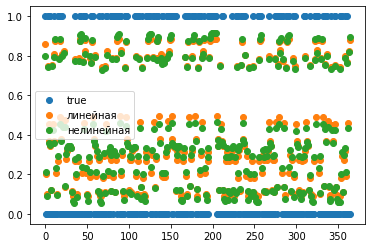

In [84]:
plt.scatter(range(period), my_weather[:,1], label='true')
plt.scatter(range(period), weather_restored[:,1], label='линейная')
plt.scatter(range(period), k_restored_weather[:,1], label='нелинейная')
plt.legend()

In [87]:
N = 100000
my_error = np.zeros(shape=(N, period))
for i in tqdm(range(N)):
  weather_m, state_m = make_sim(weather_mas, state_mas, period)
  restor = restored_weather(weather_prob, state_prob, state_m, period)
  my_error[i] = weather_m[:, 1] - restor[:, 1]

100%|██████████| 10000/10000 [00:55<00:00, 179.03it/s]


In [90]:
w, s = make_sim(weather_mas, state_mas, period)
k_restored_weather, k_cov = restored_Kalman(start, weather_prob, state_prob, s, period)

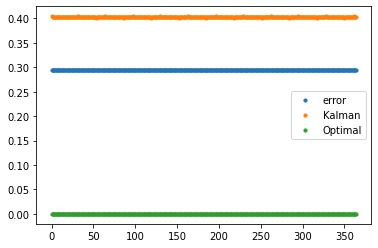

In [92]:
plt.scatter(range(period), [k_restored_weather.std()] * period, label='error', s=10)
plt.scatter(range(period), np.sqrt(k_cov[:, 1, 1]), label='Kalman', s=10)
plt.scatter(range(period), np.std(my_error, axis=0), label='Optimal', s=10)
plt.legend()

Задача 6.5. (Классификация №1) Имеются 100 несимметричных монет: n-я монета выпа-дает орлом вверх с вероятностью 𝑃𝑛=0,5+0,001×(𝑛 −50). Из монет один раз равнове-роятным образом выбирается монета, которая затем последовательно подбрасывается. По результатам подбрасывания монеты построить оценку номера выбранной монеты. Число подбрасываний 10 000.

1) На одном графике в зависимости от номера подбрасывания вывести истинный номер выбранной монеты и номер наиболее вероятной монеты.

2) На одном графике в зависимости от номера подбрасывания вывести вероятность выпа-дения орла выбранной монеты и частоту выпадения орла, реализовавшуюся в серии.

In [158]:
n = 100
N = 10000
Q = [[0.5 + 0.001 * (i - 50), 1 - (0.5 + 0.001 * (i - 50))] for i in range(1, n + 1)]

In [177]:
def create_X_Y(n, N, Q, const):
  X = np.zeros(n)
  idx = rng.choice(np.arange(n), p = [1 / n]*n)
  X[idx] = 1
  Y = np.zeros((N, const))
  Y_idx = rng.choice(np.arange(0, const), size=N, p = Q[idx])
  for i, j in enumerate(Y_idx):
    Y[i, j] = 1
  return X, Y, idx, Y_idx

In [166]:
X, Y, idx, Y_idx = create_X_Y(n, N, Q, 2)

In [188]:
def make_pred(n, N, Q, Y):
  def predict2(i):
    return P.T @ X_pred[i]


  def correct2(i, mas, Q, Y):
    res = np.zeros((n, n))
    np.fill_diagonal(res, Q @ Y[i][:, None])
    res = res @ mas
    
    return res / np.sum(res)
  X_pred = []
  X_cur = correct2(0, np.array([1. / n]*n)[:, None], Q, Y)
  X_pred.append(X_cur)
  for i in range(1, N):
    X_pr = predict2(i - 1)
    X_cur = correct2(i, X_pr, Q, Y)
    X_pred.append(X_cur)
  return X_pred

In [189]:
X_pred = make_pred(n, N, Q, Y)

In [190]:
coin_predict = list(map(np.argmax, X_pred))

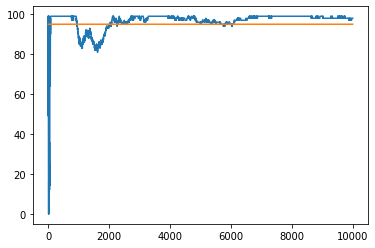

In [191]:
plt.plot(np.arange(N), coin_predict)
plt.plot(np.arange(N), [idx] * N)

In [171]:
def func_for_orel(N):
  orel_mas = []
  n = 0
  for i in range(N):
    n += int(Y_idx[i] == 0)
    orel_mas.append(n)
  return orel_mas

In [172]:
orel_ns = func_for_orel(N)

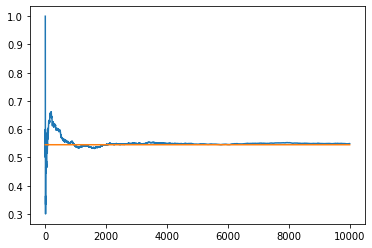

In [173]:
plt.plot(np.arange(N), orel_ns / np.arange(1, N + 1))
plt.plot(np.arange(N), [Q[idx - 1][0]]*N)

Задача 6.6. (Классификация №2) Имеются 100 несимметричных игральных костей: n-я кость имеет следующее распределение 𝑃𝑛{𝑋=𝑘}=𝐶𝑛[16+0,001×𝑐𝑜𝑠(𝜋𝑘3+𝜋𝑛50)], (𝐶𝑛 – нормировочная константа). Из костей один раз равновероятным образом выбирается одна, которая затем последовательно подбрасывается. По результатам подбрасывания кости по-строить оценку номера выбранной кости. Число подбрасываний 10 000.

1) На одном графике в зависимости от номера подбрасывания вывести истинный номер выбранной кости и номер наиболее вероятной кости.

2) На одном графике в зависимости от номера подбрасывания вывести распределение вы-бранной кости и частоты выпадения граней, реализовавшихся в серии.

In [213]:
n1 = 100
N1 = 10000
Q1 = np.zeros((n1, 6))
for i in range(Q1.shape[0]):
    for j in range(Q1.shape[1]):
        Q1[i, j] = 1/6 + 0.001 * np.cos((np.pi * j) / 3 + (np.pi * i) / 50)

In [214]:
X1, Y1, idx1, Y_idx1 = create_X_Y(n1, N1, Q1, 6)

In [215]:
X_pred1 = make_pred(n1, N1, Q1, Y1)

In [216]:
dice_predict = list(map(np.argmax, X_pred1))

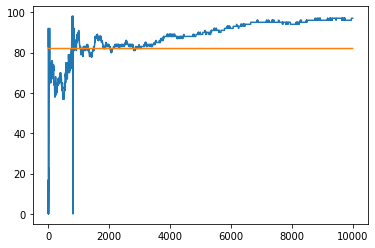

In [217]:
plt.plot(np.arange(N1), dice_predict)
plt.plot(np.arange(N1), [idx1] * N1)

In [218]:
def func_for_side(N):
  side_mas = []
  n = 0
  for i in range(N):
    n += int(Y_idx1[i] == 0)
    side_mas.append(n)
  return side_mas

In [219]:
side_mas = func_for_side(N1)

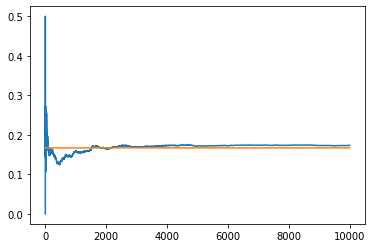

In [221]:
plt.plot(np.arange(N1), side_mas / np.arange(1, N1 + 1))
plt.plot(np.arange(N1), [Q1[idx1 - 1][0]]*N1)

Задача 6.7. Рассмотрим систему наблюдения (6.4), (6.19) со следующими параметрами:

𝑃(𝑡)= [0,90,050,050,10,80,10,20,20,6],𝐴(𝑡)= [123], 𝐵𝑛(𝑡)=1.

Начальное распределение МЦ – стационарное. На отрезке времени [0, 1000], построить абсолютно оптимальную и линейную оптимальную оценки фильтрации.

1) На каждом из трех графиков вывести индикатор состояния МЦ, «тривиальную оценку» этого индикатора, оптимальную линейную и абсолютно оптимальную оценки индика-тора.

2) Путем осреднения по пучку траекторий объемом 100 000 вычислить выборочные дис-персии ошибок нелинейных оценок индикаторов каждого состояния МЦ. На каждом из трех графиков для каждой компоненты вывести СКО индикатора компоненты, СКО ошибки оптимальной линейной оценки и СКО ошибки абсолютно оптимальной оценки.

In [235]:
n = 3
T = 1000
A, B = [np.array([1, 2, 3])[:, None], np.array([1] * n)[:, None]]

P = np.array([[0.9, 0.05, 0.05], [0.1, 0.8, 0.1], [0.2, 0.2, 0.6]])
p = np.array([4/7, 2/7, 1/7])[:, None] # т к МЦ стационарное p^P = p

In [238]:
from functools import partial

In [258]:
def create_X_Y_8(A, B, n, T):
  idx_0 = rng.choice(np.arange(n), size=1, p=p.squeeze())
  X_0 = np.zeros(n)
  X_0[idx_0] = 1
  Y_0 = A.T @ X_0 + np.sum(X_0 * B * partial(np.random.normal, loc=0.0, scale=1.0)(size=1).item())
  X, Y = [], []
  X.append(X_0)
  Y.append(Y_0)
  idx_last = idx_0
  for i in range(1, T + 1):
    idx = rng.choice(np.arange(n), size=1, p=P[idx_last].squeeze())
    X_t = np.zeros(n)
    X_t[idx] = 1
    Y_t = A.T @ X_t + np.sum(X_t * B * partial(np.random.normal, loc=0.0, scale=1.0)(size=1).item())

    X.append(X_t)
    Y.append(Y_t)
    idx_last = idx
  return X, Y

In [259]:
my_X, my_Y = create_X_Y_8(A, B, n, T)

In [262]:
import scipy.stats as sps

In [263]:
def make_pred3(A, B, n, T, Y):
  def predict3(i):
    return P.T @ X_pred[i]

  def correct3(i, mas, A, B, Y):
    temp = partial(sps.norm.pdf, loc=0.0, scale=1.0)((1. / B) * (Y[i] - A))    
    return ((mas / np.abs(B)) * temp) / np.sum((mas / np.abs(B)) * temp)

  X_pred = []
  X_cur = correct3(0, p, A, B, Y)
  X_pred.append(X_cur)
  for i in range(1, T + 1):
    X_pr = predict3(i - 1)
    X_cur = correct3(i, X_pr, A, B, Y)
    X_pred.append(X_cur)
  return X_pred

In [265]:
X_pred = make_pred3(A, B, n, T, my_Y)

In [266]:
my_X = np.stack(my_X)
X_pred = np.stack(X_pred).squeeze()

idx_real = my_X.argmax(axis=1)
idx_pred = X_pred.argmax(axis=1)

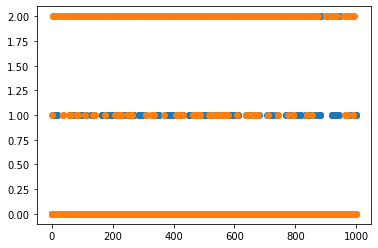

In [267]:
plt.scatter(np.arange(T + 1), idx_real)
plt.scatter(np.arange(T + 1), idx_pred)

In [269]:
sum(idx_real == idx_pred) / (T + 1)

0.44755244755244755

Задача 6.8. Рассмотрим систему наблюдения (6.4), (6.19) со следующими параметрами:

𝑃(𝑡)= [0,90,050,050,10,80,10,20,20,6],𝐴(𝑡)= [000],𝐵1(𝑡)=1,𝐵2(𝑡)=2,𝐵3(𝑡)=3.

In [270]:
n = 3
T = 1000
A, B = [np.array([0, 0, 0])[:, None], np.array([1, 2, 3])[:, None]]

P = np.array([[0.9, 0.05, 0.05], [0.1, 0.8, 0.1], [0.2, 0.2, 0.6]])
p = np.array([4/7, 2/7, 1/7])[:, None]

In [271]:
X_last, Y_last = create_X_Y_8(A, B, n, T)

In [272]:
X_pred = make_pred3(A, B, n, T, Y_last)

In [273]:
X_last = np.stack(X_last)
X_pred = np.stack(X_pred).squeeze()

idx_real = X_last.argmax(axis=1)
idx_pred = X_pred.argmax(axis=1)

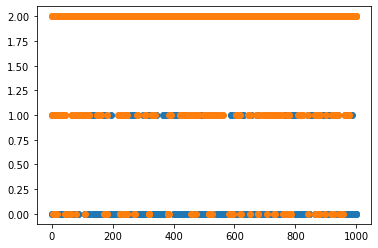

In [274]:
plt.scatter(np.arange(T + 1), idx_real)
plt.scatter(np.arange(T + 1), idx_pred)

In [275]:
sum(idx_real == idx_pred) / (T + 1)

0.18281718281718282